## Part 1: EDA & Balance

### 1 - Import and Inspect

In [42]:
import pandas as pd

url = "https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Default.xlsx"

df = pd.read_excel(url)

print(df.head())
print(df.info())
print(df.describe())

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


   Unnamed: 0 default student      balance        income
0           1      No      No   729.526495  44361.625074
1           2      No     Yes   817.180407  12106.134700
2           3      No      No  1073.549164  31767.138947
3           4      No      No   529.250605  35704.493935
4           5      No      No   785.655883  38463.495879
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   default     10000 non-null  object 
 2   student     10000 non-null  object 
 3   balance     10000 non-null  float64
 4   income      10000 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.8+ KB
None
        Unnamed: 0       balance        income
count  10000.00000  10000.000000  10000.000000
mean    5000.50000    835.374886  33516.981876
std     2886.89568    483.714985  13336.639563
min    

### 1.1 - Encode 0/1 to `Default` and `Student` columns

In [43]:
df['default'] = df['default'].map({'Yes':1,'No':0})
df['student'] = df['student'].map({'Yes':1,'No':0})
print(df.head())

   Unnamed: 0  default  student      balance        income
0           1        0        0   729.526495  44361.625074
1           2        0        1   817.180407  12106.134700
2           3        0        0  1073.549164  31767.138947
3           4        0        0   529.250605  35704.493935
4           5        0        0   785.655883  38463.495879


### 1.2 - The Imbalance

**Q:** Why would a "dumb" model that predicts 'No Default' for everyone have high accuracy?

**A:** Since only 3.33% of the dataset is composed by observations of default, a model that outputs 100% of non default would yield  96.67% of accuracy, which is remarkably high. The issue is that, obviously the model is not making any predictions, but it works in this context since the dataset is heavily imbalanced.

In [44]:
pct_default = df['default'].sum() / len(df)
print('Percentage of default:', f"{pct_default*100:.2f}","%")

Percentage of default: 3.33 %


### 1.3 - Visualization

**Q:** Boxplot the 'balance' for Defaulters vs Non-Defaulters. Do defaulters tend to carry higher balances?

**A:** Yes, which is counter intuitive. The median and most of the distribution of balance for defaulters (Default = 1) is clearly higher than for non-defaulters. So people who default tend to carry higher balances.

*** important to clarify that in this context its debt balance

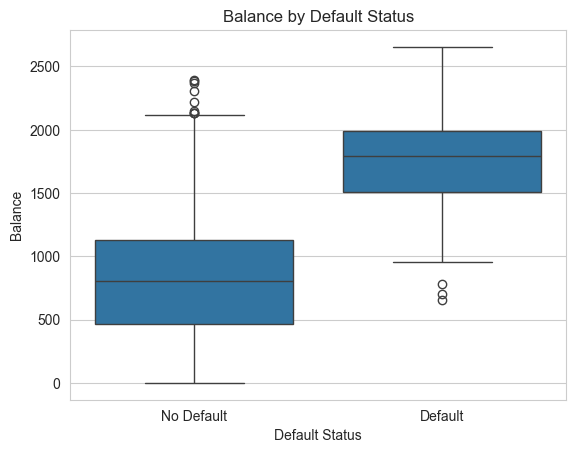

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x="default", y="balance", data=df)
plt.xticks([0, 1], ["No Default", "Default"])  # optional, nicer labels
plt.title("Balance by Default Status")
plt.ylabel("Balance")
plt.xlabel("Default Status")
plt.show()

## Part 2: Logistic Regression & Interpretability

### 2.1 - Train Test Split

In [46]:
from sklearn.model_selection import train_test_split

X = df[["student", "balance", "income"]]
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7000, 3)
(3000, 3)
(7000,)
(3000,)


### Scaling X variables

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.2 - Logistic Regression and Coefficients

**Q:** Which variable (Balance or Income) creates more risk? Does being a Student increase or decrease risk (according to the model)?

**A:** Since balance's coefficient is larger than income, both having the same sign, we can say that the variable balance creates more risk for an one unit increase. And being a student severely decreases the risk of default, because of the negative sign and the magnitude.

In [48]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

for coef, column in zip(model.coef_[0], X.columns):
    print(column, coef)

print("Intercept:", model.intercept_[0])

student -0.14939513640937338
balance 2.6861578918764333
income 0.15851729024042718
Intercept: -6.000036144150306


### 2.3 - Feature Selection (Lasso)

Fit a Logistic Regression with `penalty='l1'` and `solver='liblinear'`. Try a small `C` (e.g., 0.01).

**Q:** Did any coefficients drop to zero? What does this imply?

**A:** With `C=0.01`,both student and income coefficient go to zero. This implies that the penalty induced by the LASSO approach shrinks to 0 the ceefficients that contribute very little to predicting the default probability, keeping only the most relevant variables.

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model2 = LogisticRegression(solver="liblinear", penalty='l1', C=0.01, random_state=1)

model2.fit(X_train_scaled, y_train)

for coef, column in zip(model2.coef_[0], X.columns):
    print(column, coef)

print("Intercept:", model2.intercept_[0])

student 0.0
balance 1.0605809579944092
income 0.0
Intercept: -3.4951140039062807


## Part 3: The Metric Battle (LogReg vs KNN)
5. **The Verdict:** As a Risk Manager, you must choose one model to deploy.

- **Scenario A:** Your bank is conservative and fears losing principal (Needs high Recall). Which model do you pick?

- **Scenario B:** Your bank wants to grow and fears rejecting good customers (Needs high Precision). Which model do you pick?

- **Final Decision:** Considering Explainability (Part 2) and Performance (Part 3), which model is the most realistic choice for a regulated financial institution?


### 3.1 - Fitting a KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier

model3 = KNeighborsClassifier(n_neighbors=9)
model3.fit(X_train_scaled, y_train)

model3_pred = model3.predict(X_test_scaled)
model3_proba = model3.predict_proba(X_test_scaled)[:, 1]


model2_pred = model.predict(X_test_scaled)
model2_proba = model.predict_proba(X_test_scaled)[:, 1]

### 3.2 - Trade-off Analysis
- **Recall:** Which model is safer (misses fewer defaults)? **A:** Both models have the same performance
- **Precision:** Which model is more efficient (falsely accuses fewer good customers)? **A:** Logistical Regression
- **F1-Score:** Which model provides the best balance? **A:** Logistic Regression
- **AUC:** Which curve is closer to the top-left corner? **A:** Logistic Regression's Curve

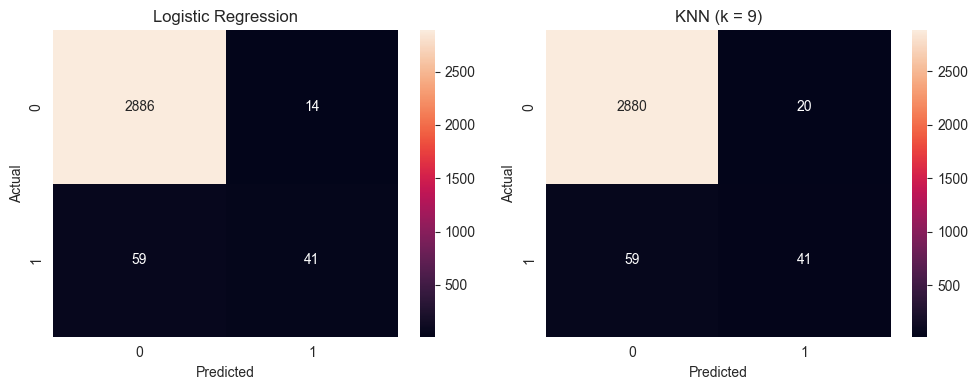

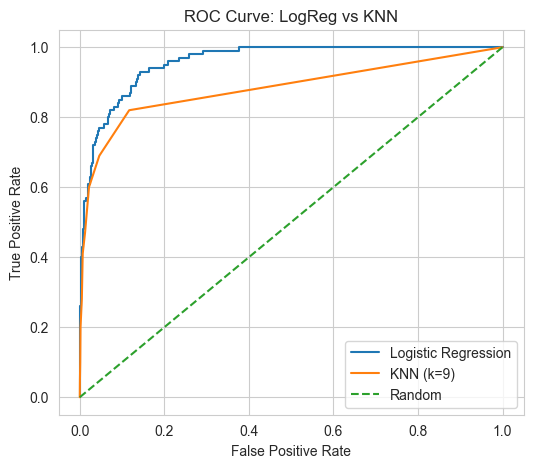

                     Recall (Default=1)  Precision (Default=1)  \
Model                                                            
Logistic Regression                0.41               0.745455   
KNN (k=9)                          0.41               0.672131   

                     F1-Score (Default=1)   ROC-AUC  
Model                                                
Logistic Regression              0.529032  0.958555  
KNN (k=9)                        0.509317  0.881817  


In [51]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve


# Confusion matrices
cm_log = confusion_matrix(y_test, model2_pred)
cm_knn = confusion_matrix(y_test, model3_pred)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(cm_log, annot=True, fmt="d", ax=axes[0])
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_knn, annot=True, fmt="d", ax=axes[1])
axes[1].set_title("KNN (k = 9)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Metrics DataFrame
rows = []

for name, y_pred, y_proba in [("Logistic Regression", model2_pred, model2_proba), ("KNN (k=9)", model3_pred, model3_proba)]:
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, pos_label=1, average="binary")
    roc_auc = roc_auc_score(y_test, y_proba)

    rows.append({
        "Model": name,
        "Recall (Default=1)": recall,
        "Precision (Default=1)": precision,
        "F1-Score (Default=1)": f1,
        "ROC-AUC": roc_auc
    })

fpr_log, tpr_log, _ = roc_curve(y_test, model2_proba)
fpr_knn, tpr_knn, _ = roc_curve(y_test, model3_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_knn, tpr_knn, label="KNN (k=9)")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: LogReg vs KNN")
plt.legend()
plt.grid(True)
plt.show()

metrics_df = pd.DataFrame(rows).set_index("Model")
print(metrics_df)

**The Verdict:** As a Risk Manager, I would pick the Logistic Regression as my main model because of its higher ability to identify defaulting costumers and because of well known and simple structure.

- **Scenario A:** Your bank is conservative and fears losing principal (Needs high Recall). Which model do you pick?
    - **A:** Both models show the same recall. Given that logistical regressions are more widely employed and understood, it would be my go to choice.

- **Scenario B:** Your bank wants to grow and fears rejecting good customers (Needs high Precision). Which model do you pick?
    - **A:** Logistical Regression, as it produced less false negatives (predicting a default for a good costumer).

- **Final Decision:** Considering Explainability (Part 2) and Performance (Part 3), which model is the most realistic choice for a regulated financial institution?
    - **A:** I would pick Logistic regression as it is well stablished, easy to interpret and explain to non-specialist, and, of course because in the metrics used herein it performed slightly better. Nevertheless, it must be noted that to be able to properly assess which model performs better, we would need more information such as the loan value, recovery rate, interest rates and other, to assess the profit and losses that each model would produce.